In [ ]:
#drive_path = "Downloads/Medical_MNIST.zip"

#Mount drive
# from google.colab import drive
# drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/Assignment1_ELL409/Q3/Medical_MNIST.zip" #replace with local directory
# drive_path1 = "/content/drive/MyDrive/Assignment1_ELL409/Q1/health_data.csv"

#report: https://www.overleaf.com/read/nrmtrnjwfgnh

In [ ]:
import numpy as np
import pandas as pd
import statistics as st
import math
from zipfile import ZipFile as zipf
from PIL import Image as img
import matplotlib.pyplot as plt

In [ ]:
def confusion_matrx(out_true_dict,num_class):
    conf_m = np.zeros(dtype=int,shape=(num_class,num_class))

    for i in out_true_dict.keys():
        true_v = int(i)
        pred_vs = out_true_dict[i]
        for pred_v in pred_vs:
          conf_m[true_v][int(pred_v)] +=1

    return conf_m

def accuracy(out_dict,num_class):
    acc = 0
    conf_m = confusion_matrx(out_dict,num_class)
    for i in range(num_class):
        acc += conf_m[i][i]
    acc = acc/sum(sum(conf_m))

    return acc

def balanced_acc_sckit(out_dict,num_class):
  C = confusion_matrx(out_dict,num_class)
  with np.errstate(divide='ignore', invalid='ignore'):
      per_class = np.diag(C) / C.sum(axis=1)
  if np.any(np.isnan(per_class)):
      warnings.warn('y_pred contains classes not in y_true')
      per_class = per_class[~np.isnan(per_class)]
  score = np.mean(per_class)
  if 1==1:
      n_classes = len(per_class)
      chance = 1 / n_classes
      score -= chance
      score /= 1 - chance
  return score


def precis_recall_f(out_dict,num_class,cf):
    if not out_dict:
      cfm = cf
    else:
      cfm = confusion_matrx(out_dict,num_class)
    
    if(num_class==2):
      precision = (1/(cfm[1][1] + cfm[0][1]))*cfm[1][1]
      recall = (1/(cfm[0][0] + cfm[1][0]))*cfm[0][0]
      fscore = 2*precision*recall*(1/(precision+recall))
      return precision,recall,fscore
  
    precs = []
    recs = []
    fs = []
    for i in range(num_class):
        precision = cfm[i][i]
        if(precision!=0):
          precision = precision/sum([cfm[t][i] for t in range(num_class)])
        
        recall = cfm[i][i]
        if(recall!=0):
          recall = recall/sum([cfm[i][t] for t in range(num_class)])
        
        tm = precision+recall
        if(tm>0):
          fscore = 2*precision*recall/tm
        else:
          fscore=0
        precs.append(precision)
        recs.append(recall)
        fs.append(fscore)

    macrp = sum(fs)/num_class

    return precs,recs,fs,macrp


Start of data preprocessing

In [ ]:
np.random.seed(0)

def split_data(data,r,flag): 
    '''r: ratio of split, r indicates amount in train; flag indicates if random or linear split'''
    train_len = int(len(data) * r)
    
    test_len = len(data) - train_len
    test = [] 
    train = []

    if(flag==0):
        train = list(data)
        while len(test) < test_len:
            inx = np.random.randint(0,len(train))
            test.append(train.pop(inx))
    
    else:
        train = data
        while len(test) < test_len:
            inx = 0
            test.append(train.pop(inx))

    return train, test 

def split_cv(dataset, folds=5):
    #modified version of code from https://machinelearningmastery.com/implement-resampling-methods-scratch-python/ for convenience
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = np.random.randint(0,len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    inx = 0
    while(len(dataset_copy)!=0):
      dataset_split[inx].append(dataset_copy.pop(0))
      inx+=1
    
    del(dataset_copy)
    return dataset_split

In [ ]:
def key_feat_map(data_arr):
  dict1 = {}
  for lst in data_arr:
    k = lst[-1]
    if k in dict1.keys():
      dict1[k].append(lst[:-1])
    else:
      dict1[k] = [np.asarray(lst[:-1])]
  for k in dict1:
    dict1[k] = np.asarray(dict1[k])
    #print(dict1[k].shape)
  return dict1

In [ ]:
#Multiclass
categories = {"AbdomenCT":0,"BreastMRI":1,"CXR":2,"ChestCT":3,"Hand":4,"HeadCT":5}
#all_vals = {0:[],1:[],2:[],3:[],4:[],5:[]}
all_vals_lst = []
with zipf(drive_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:
            key = file.name.split('/')[0]
            imag = img.open(file)
            #imag = imag.resize((32,32))
            #print(imag.size, imag.mode, len(imag.getdata()))
            #print()
            lst = list(imag.getdata())
            lst.append(categories[key])
            #all_vals[categories[key]].append(np.asarray(imag.getdata()))
            all_vals_lst.append(np.asarray(lst))
            del(lst)

all_vals_lst = np.asarray(all_vals_lst)

In [ ]:
#sanity checks
#np.random.shuffle(all_vals_lst)
#print(len(all_vals_lst))
#print(len(traindata))
# print(len(testdata)+len(traindata))

In [ ]:
traindata,testdata = split_data(all_vals_lst,0.8,0)
traindata = np.asarray(traindata)
testdata = np.asarray(testdata)

47163
58954


In [ ]:
 #free ram, size of that array wld be large
 #del(all_vals_lst)

In [ ]:
#Applying PCA

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(traindata[:,:-1])
traindata[:,:-1] = scaler.transform(traindata[:,:-1])
testdata[:,:-1] = scaler.transform(testdata[:,:-1])

#using sklearn because when I used my implementation the code kept crashing, bec. RAM capacity not enough (even on google colab.); code blow:
#add original code from old file)

# def standardize_data(train_d,test_d,eps=10^-3):
#   mu_arr = np.mean(train_d,axis=0)
#   sd_arr = np.std(train_d,axis=0)
#   for val in range(len(sd_arr)):
#     if(sd_arr[val]==0):
#       sd_arr[val] = eps
  
#   for val in range(len(train_d)):
#     lst_tr = train_d[val]
    
#     lst_tr = np.subtract(lst_tr,mu_arr)
#     train_d[val] = np.divide(lst_tr,sd_arr)
    
#   for val in range(len(test_d)):
#     lst_ts = test_d[val]
#     lst_ts = np.subtract(lst_ts,mu_arr)
#     test_d[val] = np.divide(lst_ts,sd_arr)

#   scaler = StandardScaler()
#   # Fit on training set only.
#   scaler.fit(train_img)
#   # Apply transform to both the training set and the test set.
#   train_img = scaler.transform(train_img)
#   test_img = scaler.transform(test_img)

#   return train_d,test_d

# def std_dicts(train_dict,test_dict):
#   for key in train_dict.keys():
#     train_dict[key],test_dict[key] = standardize_data(train_dict[key],test_dict[key])
#   return train_dict,test_dict


In [ ]:
#num_c = 5
num_c = 3
from sklearn.decomposition import PCA
pca = PCA(n_components=num_c)
pca.fit(traindata[:,:-1])

train_set1 = pca.transform(traindata[:,:-1])
test_set1 = pca.transform(testdata[:,:-1])

train_pca1 = []
for i in range(len(traindata)):
  feat = traindata[i,-1]
  k = list(train_set1[i,:])
  k.append(feat)
  train_pca1.append(np.asarray(k))

test_pca1 = []
for i in range(len(testdata)):
  feat = testdata[i,-1]
  k = list(test_set1[i,:])
  k.append(feat)
  test_pca1.append(np.asarray(k))

k_folds3 = split_cv(train_pca1)
for i in range(5):
  print(len(k_folds1[i]))

test_pca3 = key_feat_map(test_pca1)
del(test_pca1)

# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/5Fold_3PCA.pickle","wb") as f:
#   pickle.dump(k_folds3,f)

# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/testdict_3PCA.pickle","wb") as f:
#   pickle.dump(test_pca3,f)



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(traindata[:,:-1])

train_set = pca.transform(traindata[:,:-1])
test_set = pca.transform(testdata[:,:-1])


# num C vs variance plot
# var = []
# nc = []
# for k in range(5,55,10):
#   pca = PCA(n_components=k)
#   pca.fit(traindata)

#   train_set = pca.transform(traindata)
#   #test_set = pca.transform(testdata)
#   print("---" + str(k) + "---")
#   lst_v = []
#   for inx in range(k):
#     print(inx)
#     lst_v.append(np.std(np.asarray(train_set[:,inx])))
#   var.append((max(lst_v),min(lst_v),np.mean(np.asarray(lst_v))))
#   nc.append(k)

# plt.scatter(nc,[t[0] for t in var],label="max")
# plt.scatter(nc,[t[1] for t in var],label="min")
# plt.scatter(nc,[t[2] for t in var],label="mean")
# plt.legend()
# plt.xlabel("PCA num components")
# plt.ylabel("variance")
# plt.savefig("/content/drive/MyDrive/Assignment1_ELL409/PCA_plot.png")
# plt.show()


In [ ]:
train_pca = []
for i in range(len(traindata)):
  feat = traindata[i,-1]
  k = list(train_set[i,:])
  k.append(feat)
  train_pca.append(np.asarray(k))

test_pca = []
for i in range(len(testdata)):
  feat = testdata[i,-1]
  k = list(test_set[i,:])
  k.append(feat)
  test_pca.append(np.asarray(k))


In [ ]:
# sanity checks
# print(len(train_pca[0]))
# print(len(test_pca)+len(train_pca))

6
58954


In [ ]:
k_folds = split_cv(train_pca)
for i in range(5):
  print(len(k_folds[i]))

In [ ]:
test_pca = key_feat_map(test_pca)

In [ ]:
import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#modification of code taken from: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def plot_cm(cm,num_c,title_in,fs=1,fz=10):

  array = cm
  df_cm = pd.DataFrame(array, range(num_c), range(num_c))
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=fs) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": fz}) # font size
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(title_in)
  plt.show()
  return 0

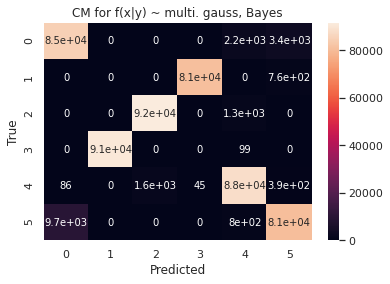

0

In [ ]:
plot_cm([[84965,0,0,0,2164,3394],[0,0,0,81078,0,755],[0,0,91570,0,1261,0],[0,90592,0,0,99,0],[86,0,1617,45,88341,389],[9664,0,0,0,801,80832]],6,"CM for f(x|y) ~ multi. gauss, Bayes")

In [ ]:
#if req to clear ram
#del(all_vals_lst) 

In [ ]:
# #saving code
# import pickle
# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/5Fold_5PCA.pickle","wb") as f:
#   pickle.dump(k_folds,f)

# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/testdict_5PCA.pickle","wb") as f:
#   pickle.dump(test_pca,f)

In [ ]:
#all prior code is uncommented for submission purpose
#prior to submission I saved test_pca and k_folds and used to load them using this

# import pickle
# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/5Fold_5PCA.pickle","rb") as f:
#   k_folds = pickle.load(f)

# with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/testdict_5PCA.pickle","rb") as f:
#   test_pca = pickle.load(f)

In [ ]:
# datavisualizatio
# all_tr = k_folds[0]
# for i in range(1,5):
#   all_tr.extend(k_folds[i])

# plt_tr = key_feat_map(all_tr)

# tr_v = []
# ts_v = []
# for key in plt_tr.keys():
#   tr_v.append(len(plt_tr[key]))
#   ts_v.append(len(test_pca[key]))

# tr_v = [x/sum(tr_v) for x in tr_v]
# ts_v = [x/sum(ts_v) for x in ts_v]
# baselin = [1/6 for i in range(6)]

# plt.plot(range(len(tr_v)),tr_v,label="train")
# plt.plot(range(len(ts_v)),ts_v,label="test")
# plt.plot(range(6),baselin,'--',label="1/6")
# plt.ylabel("Fraction in dataset")
# plt.xlabel("Class Label")
# plt.legend()
# #plt.savefig("/content/drive/MyDrive/Assignment1_ELL409/dataVis_1.png")
# --------------------------
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# #plt.hold(True)
# for k in train_pca3.keys():
#   plt.scatter(train_pca3[k][:,0],train_pca3[k][:,1],train_pca3[k][:,2])
# plt.show()

Bayes classifier, f(x|y) ~ multivariate normal

In [ ]:
def MLE_Gaussian_Params(data_lst):
  #MLE parameters obtained via closed form expression
  n = data_lst.shape[0] #number of data points
  k = data_lst.shape[1] #feature vector dimension
  mu = data_lst[0][:]
  for j in range(1,n):
    mu = mu + data_lst[j][:]
  mu = mu/n
  
  sd = np.zeros(shape=(k,k),dtype=float)
  #print(k)
  for j in range(n):
    tmp = data_lst[j][:] - mu
    #print(np.transpose(tmp[np.newaxis]).shape)
    sd += np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis])
  
  sd = sd/n
  
  return mu,sd

def PDF_normaldistr(inpt,mu,sd):
  #mu = lst[0]
  #sd = lst[1]
  #print("in pdf")
  tmp = inpt-mu
  tmp = tmp[np.newaxis]
  k = tmp.shape[1]
  dt = np.linalg.det(sd)
  if(dt!=0):
    #print("det nonzero")    
    sdi = np.linalg.inv(sd)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    expt = math.exp(expt[0][0])
    #print("---")
    #print(expt)
    #print(((2*math.pi)**(-0.5*k))*((dt)**(-0.5)))
    #print("---")
    return expt*((2*math.pi)**(-0.5*k))*((dt)**(-0.5))
  
  else:
    print("0 det")
    #add gaussian noise when determinant of covariance 0
    sd1 = sd + np.random.normal(0,1,size=sd.shape)
    sd1 = np.matmul(np.transpose(sd1),sd1)
    sdi = np.linalg.inv(sd1)
    dt = np.linalg.det(sd1)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    expt = math.exp(expt[0][0])
    return expt*((2*math.pi)**(-0.5*k))*((dt)**(-0.5))


def predict_label_MLEGauss(lst,lst_params,prior_arr):

  out_lab = (-1,0)

  for indx in range(len(lst_params)):
    theta = lst_params[indx]
    fx_y = prior_arr[indx]
    fx_y = fx_y*PDF_normaldistr(lst,theta[0],theta[1])
    
    #print(fx_y)
    if(out_lab[0]==-1):
      out_lab = (fx_y,indx)

    else:
      if(out_lab[0]<fx_y):
        out_lab = (fx_y,indx)

  return out_lab[1]

def classify_MLE_Gauss(train_data_dict,test_data_dict,prior_arr,num_c):
  lst_params = []
  #true_class = []
  given_num_c = 0
  for k in train_data_dict.keys():
    lst_d = train_data_dict[k]
    mu,sd = MLE_Gaussian_Params(lst_d)
    lst_params.append((mu,sd))
    given_num_c+=1
  
  dict_true_out = {}
  for ky in test_data_dict.keys():
    lst_d = test_data_dict[ky]
    out_list = []
    for arr in lst_d:
      out_l = predict_label_MLEGauss(arr,lst_params,prior_arr)
      out_list.append(out_l)
    
    dict_true_out[ky] = out_list
    
  return lst_params,accuracy(dict_true_out,num_c),confusion_matrx(dict_true_out,num_c)

def dict_label_gauss(test_data_dict,lst_params,prior_arr):
  dict_true_out = {}
  for ky in test_data_dict.keys():
    lst_d = test_data_dict[ky]
    out_list = []
    for arr in lst_d:
      out_l = predict_label_MLEGauss(arr,lst_params,prior_arr)
      out_list.append(out_l)
    
    dict_true_out[ky] = out_list
  
  return dict_true_out

In [ ]:
#doing k-fold cv on this
best_tup = [-1,list(),list(),0]
tr_accs = np.zeros(len(k_folds))
for i in range(len(k_folds)):
  temp_test = key_feat_map(k_folds[i])
  
  temp_train = []
  for j in range(len(k_folds)):
    if(j!=i):
      temp_train.extend(k_folds[j])
  tot_train = len(temp_train)
  temp_train = key_feat_map(temp_train)
  
  mle_p = np.ones(shape=6)
  for k in temp_train.keys():
    mle_p[int(k)] = len(temp_train[k])/tot_train

  params,acc,conf_m = classify_MLE_Gauss(temp_train,temp_test,mle_p,6)
  tr_accs[i] = acc
  if(acc>best_tup[0]):
    best_tup = [acc,params,mle_p,i,conf_m]
  del(temp_test)
  del(temp_train)

print(best_tup[0])
print(np.mean(tr_accs))
print(accuracy(dict_label_gauss(test_pca,best_tup[1],best_tup[2]),6))

In [ ]:
print(best_tup[4])

[[1497    0    0    0   50   76]
 [   0    0    0 1460    0   13]
 [   0    0 1508    0   15    0]
 [   0 1594    0    0    1    0]
 [   2    0   21    3 1611   11]
 [ 158    0    0    0   17 1396]]


In [ ]:
print(precis_recall_f({},6,best_tup[4]))

([0.9034399517199758, 0, 0.9862655330281229, 0, 0.9510035419126328, 0.9331550802139037], [0.922365988909427, 0, 0.990151017728168, 0, 0.9775485436893204, 0.8886059834500318], [0.9128048780487806, -1, 0.9882044560943644, -1, 0.9640933572710951, 0.9103358330616238], 0.29590642074597734)


In [ ]:
l1 = [[0.9034399517199758, 0, 0.9862655330281229, 0, 0.9510035419126328, 0.9331550802139037],[0.922365988909427, 0, 0.990151017728168, 0, 0.9775485436893204, 0.8886059834500318],[0.9128048780487806, 0, 0.9882044560943644, 0, 0.9640933572710951, 0.9103358330616238]]
l2 = [[0.8659315147997678, 1.0, 0, 0.277878022374594, 0, 0.964259121370067],[0.9209876543209876, 0.5805770584095707, 0, 0.982769623484365, 0, 0.7862780813600486],[0.8926114268620999, 0.7346393588601958, 0, 0.4332536221690814, 0, 0.8662207357859533]]

In [ ]:
for t in l2:
  t = [round(t1,3) for t1 in t]
  print(str(t)[1:-1].replace(","," "))

0.866  1.0  0  0.278  0  0.964
0.921  0.581  0  0.983  0  0.786
0.893  0.735  0  0.433  0  0.866


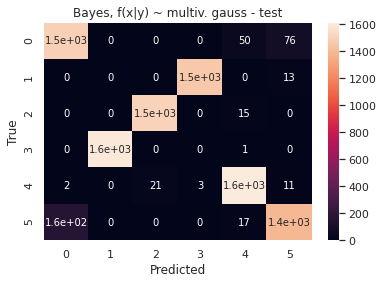

0

In [ ]:
plot_cm(best_tup[4],6,"Bayes, f(x|y) ~ multiv. gauss - test")

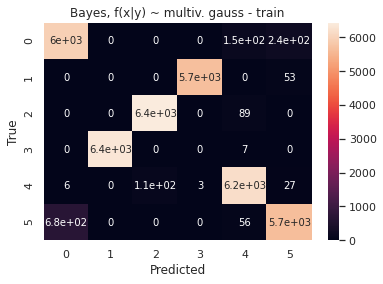

0.6430956798303737


In [ ]:
tmp_train = []
for i in range(len(k_folds)):
  if(i!=best_tup[3]):
    tmp_train.extend(k_folds[i])
tmp_train = key_feat_map(tmp_train)
tr_cm = confusion_matrx(dict_label_gauss(tmp_train,best_tup[1],best_tup[2]),6)
plot_cm(tr_cm,6,"Bayes, f(x|y) ~ multiv. gauss - train")
print(accuracy(dict_label_gauss(tmp_train,best_tup[1],best_tup[2]),6))

Bayes classifier, f(x|y)~ GMM

In [ ]:
# import scipy.stats as spt

def PDF_normaldistr1(inpt,mu,sd):
  #handles overflow underflow etc for EM
  # sanity check: return float(scipy.stats.multivariate_normal(inpt,mu,sd))
  tmp = inpt-mu
  #try block to see if std deviation arr or int, to make code work for Naive bayes too
  try:
    k = len(sd)
  except:
    return pdf_uniGauss(inpt,[mu,sd])

  tmp = tmp[np.newaxis]
  k = tmp.shape[1]
  dt = np.linalg.det(sd)
  
  if(dt>10**-7):
    #var = spt.multivariate_normal(mu, sd)
    #return var.pdf(inpt)
    #print("det nonzero")    
    dt = np.linalg.det(sd)
    sdi = np.linalg.inv(sd)
    expt = np.matmul(tmp,sdi)
    expt = np.matmul(expt,np.transpose(tmp))*(-0.5)
    #print(expt)
    over_v = 0
    if(expt>20):
      expt = [[10]]
      over_v = 2**(-10)
    elif(expt<-20):
      expt = [[-10]]
      over_v = 2**(-10)
    
    t2 = ((2*math.pi)**(-0.5*k))*((dt)**(-0.5))
    v = float(t2*np.exp(expt))
    if(math.isnan(v)):
      #print('nan')
      v = over_v
    return v
  
  else:
    #print("0 det")
    sd1 = sd + np.random.normal(0,4,size=sd.shape)
    sd1 = np.matmul(sd1.transpose(),sd1)
    #print(np.linalg.det(sd1))
    return PDF_normaldistr1(inpt,mu,sd1)

#EM FOR GMMs, (coeff*multivariate gaussian)

def latent_probs(data,gmm_coeffs,gmm_mu,gmm_sd):
  num_data = len(data)
  gamma_wts = np.zeros(shape=(num_data,len(gmm_coeffs)))
  #normal_distrn = [,pdf_uniGauss]
  #all_j_sums = []
  for i in range(len(data)):
    temp_sum = 0
    for j in range(len(gmm_coeffs)):
      
      val = PDF_normaldistr1(data[i],gmm_mu[j],gmm_sd[j])
    #  print(val)
    #  print(data[i])
    #  print(gmm_mu[j])
    #  print(gmm_sd[j])
      gamma_wts[i][j] = val*gmm_coeffs[j]
    #  print("val is: " + str(val))
    #  print("coeff is: " + str(gmm_coeffs[j]))
      temp_sum += val*gmm_coeffs[j]
      #all_j_sums.append(temp_sum)
    #print(temp_sum)
    if(temp_sum==0):
        temp_sum = 10**-4
    gamma_wts[i,:] = gamma_wts[i,:]/temp_sum

  return gamma_wts 

def find_maximized(data,gamma_wts):
  gmm_mu = []
  gmm_coeffs = []
  gmm_sd = []
  n = gamma_wts.shape[0]
  #print(gamma_wts.shape)
  for k in range(gamma_wts.shape[1]):
    pi_k = (1/n)*(np.sum(gamma_wts[:,k]))
    if(pi_k==0):
        pi_k = 10**-4
    try:
      mu_k = np.zeros(shape=len(data[0]))
      for i in range(n):
        mu_k += [gamma_wts[i][k]*t for t in data[i]] ##might give bt with data[i] not iterable
      mu_k = mu_k/(n*pi_k)
    
      sd_k = np.zeros(shape=(len(data[0]),len(data[0])))
      for j in range(n):
        tmp = data[j] - mu_k
        sd_k += np.multiply(np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis]),gamma_wts[j][k])  
      sd_k = sd_k/(n*pi_k)
    
    except:
      mu_k = np.zeros(shape=1)
      for i in range(n):
        mu_k += gamma_wts[i][k]*data[i]
      mu_k = mu_k/(n*pi_k)

      sd_k = np.zeros(shape=(1,))
      for j in range(n):
        tmp = np.asarray([data[j]]) - mu_k
        sd_k += np.multiply(np.matmul(np.transpose(tmp[np.newaxis]),tmp[np.newaxis]),gamma_wts[j][k])[0]  
      sd_k = sd_k/(n*pi_k)
    
    gmm_coeffs.append(pi_k)
    gmm_mu.append(mu_k)
    gmm_sd.append(sd_k)

  return gmm_coeffs,gmm_mu,gmm_sd

def logLikeli_EMM(data,gmm_coeffs,gmm_mu,gmm_sd,gamma_coeffs):
  logl = 0
  for i in range(len(data)):
    for j in range(len(gmm_coeffs)):
     #pdf_normval = 0 
      #try: 
      pdf_normval = PDF_normaldistr1(data[i],gmm_mu[j],gmm_sd[j])
      #except:
       # new_sd = gmm_sd[j] + np.random.normal(0,1,shape=gmm_sd[j].shape)
        #pdf_normval = PDF_normaldistr(data[i],gmm_mu[j],new_sd)
      #finally:
      ep = 0
      #print(gmm_coeffs[j])
      #print(pdf_normval)
      v1 = abs(gmm_coeffs[j]*pdf_normval)
      if(v1==0):
        ep = 10**-3
       # print(ep)  
      val = math.log(v1+ep)
      val = val*gamma_coeffs[i][j]
      logl+=val
  
  return logl
  #print("bpp")

def EM_GMMs(n,data_lst,init_coeff,init_mu,init_sd,tolr=10^-3,maxiter=200):
  stopCon=False
  
  init_logL,temp_logL = 0,0

  iter = 0
  if(len(init_coeff)>4):
    maxiter = maxiter*len(init_coeff)
    print(maxiter)
  canCal = True
  while(stopCon==False):
    #print("iter is: " + str(iter))
    if(len(data_lst)>300):
      indxs = np.random.choice(range(len(data_lst)),300, replace=False)
      data_new = [data_lst[inx] for inx in indxs]
    else:
      data_new = data_lst
    init_gm_wts = latent_probs(data_new,init_coeff,init_mu,init_sd)
    gmmc,gmmm,gmmsd = find_maximized(data_new,init_gm_wts)
    #print(init_gm_wts)
    #break
    #print([gmmc,gmmm,gmmsd])
    #init_gm_wts = latent_probs(n,data_lst,gmmc,gmmm,gmmsd)
    init_logL = temp_logL
    try:
      temp_logL = logLikeli_EMM(data_new,gmmc,gmmm,gmmsd,init_gm_wts)
      canCal = True
    except:
      canCal = False #checks put in place bec. inspite of handling overfl, underfl, math domain - loglikelihood gives math errors in some fringe cases
      #print(canCal)

    iter+=1
    del(data_new)
    if(canCal):
      if(abs(init_logL-temp_logL)<tolr or iter>maxiter):
        stopCon = True
        print(iter)
        print(abs(init_logL-temp_logL))

    else:
      if(iter>maxiter):
        stopCon = True
        print(iter)
        print(abs(init_logL-temp_logL))
  print("bpp")
  return gmmc,gmmm,gmmsd

def pdf_GMM(inpt,params):
  gmm_c,gmm_m,gmm_sd = params[0],params[1],params[2]
  val = 0
  for t in range(len(gmm_c)):
    val += gmm_c[t]*PDF_normaldistr1(inpt,gmm_m[t],gmm_sd[t])
  return val

def MLE_predictLab_GMM(inpt,params_arr,prior_arr):
  #all_vals = []
  max_val = (-1,0)
  for key in params_arr.keys():
    params = params_arr[key]
    val = prior_arr[int(key)]
    val = val*pdf_GMM(inpt,params)

    if(max_val[0]==-1):
      max_val = (val,key)
    else:
      if(max_val[0]<val):
        max_val = (val,key)

  return max_val[1] 

def find_params_traindict(train_dict,init_guess):
  params_dict = {}
  for k in train_dict.keys():
      c,mu,sd = EM_GMMs(len(train_dict[k]),train_dict[k],init_guess[0],init_guess[1],init_guess[2])
      params_dict[k] = (c,mu,sd)
  return params_dict

def tested_labs(test_dict,params_dict,prior_arr):
  tested_labels = {}
  for k in test_dict.keys():
    feats = test_dict[k]
    out_labs = []
    for feat in feats:
      labl = MLE_predictLab_GMM(feat,params_dict,prior_arr)
      out_labs.append(labl)
    tested_labels[k] = out_labs
  return tested_labels

def MLE_Bayes_GMM(train_dict,test_dict,init_guess,prior_arr1,num_c):
  params_dict = find_params_traindict(train_dict,init_guess)

  tested_labels = tested_labs(test_dict,params_dict,prior_arr1)
  test_acc = accuracy(tested_labels,num_c)

  return params_dict,test_acc,confusion_matrx(tested_labels,num_c)

In [ ]:
def generate_random_initguess(num_comps,num_feat,coeff=1,ub=25):
  gmm_coeffs = [1/num_comps for t in range(num_comps)]
  if(num_feat==1):
    gmm_mu = [np.random.rand(1) for i in range(num_comps)]
    gmm_sd = [np.random.randint(1,4) for i in range(num_comps)]
    return {0:gmm_coeffs,1:gmm_mu,2:gmm_sd}
  
  gmm_mu = [np.random.rand(num_feat) for i in range(num_comps)]
  #k = len(train_d)/(5*num_comps)
  gmm_sd = [np.cov([np.random.randint(0,ub,size=6) for t in range(num_feat)]) for k11 in range(num_comps)]
  gmm_sd = [np.matmul(np.transpose(tmp),tmp) for tmp in gmm_sd]
  print([np.linalg.det(t) for t in gmm_sd])
  return {0:gmm_coeffs,1:gmm_mu,2:gmm_sd}

In [ ]:
#generate_random_initguess(2,5)

In [ ]:
#doing k-fold cv on this
#init_g = generate_random_initguess(num_comps,5)
#init_g = best_tup[1]

best_tup = [-1,list(),list(),0]
num_comps = 2
all_tups = []
#print(len(all_tups1))

for i in range(len(k_folds)):
  np.random.seed(i)
  temp_test = key_feat_map(k_folds[i])
  init_g = guesses_int[i]
  temp_train = []
  for j in range(len(k_folds)):
    if(j!=i):
      temp_train.extend(k_folds[j])
  
  tot_train = len(temp_train)
  #print(np.cov(np.asarray(temp_train)))
  
  #print(init_g[2][0])
  #break
  temp_train = key_feat_map(temp_train)
  
  mle_p = np.ones(shape=6)
  for k in temp_train.keys():
    mle_p[int(k)] = len(temp_train[k])/tot_train
  
  params,acc,cm = MLE_Bayes_GMM(temp_train,temp_test,init_g,mle_p,6)
  all_tups.append([acc,params,mle_p,i,cm])
  if(acc>best_tup[0]):
    best_tup = [acc,params,mle_p,i,cm]
  #break
print(best_tup[0])

In [ ]:
#print(best_tup[1])
all_tups1 = [t[1] for t in all_tups]
print(all_tups1[0][0])
guesses_int = []
for k in all_tups1:
  dct = {}
  iz = np.random.randint(0,6,size=3)
  dct[0] = k[iz[0]][0]
  dct[1] = k[iz[1]][1]
  dct[2] = k[iz[2]][2]
  guesses_int.append(dct)

([0.0261595968552636, 0.9738404031447365], [array([ 4.16133574, -2.07188781,  2.78675042, -3.33089132,  1.0502281 ]), array([ 4.16133574, -2.07188781,  2.78675042, -3.33089132,  1.0502281 ])], [array([[ 3.85199948, -0.6888772 ,  1.84996562, -2.41251965,  0.23625981],
       [-0.6888772 ,  0.71289171, -0.88127953,  0.66801906, -0.43048782],
       [ 1.84996562, -0.88127953,  2.8014153 , -2.56409746,  1.41146139],
       [-2.41251965,  0.66801906, -2.56409746,  5.33881698, -2.63050331],
       [ 0.23625981, -0.43048782,  1.41146139, -2.63050331,  3.24180843]]), array([[ 3.85199948, -0.6888772 ,  1.84996562, -2.41251965,  0.23625981],
       [-0.6888772 ,  0.71289171, -0.88127953,  0.66801906, -0.43048782],
       [ 1.84996562, -0.88127953,  2.8014153 , -2.56409746,  1.41146139],
       [-2.41251965,  0.66801906, -2.56409746,  5.33881698, -2.63050331],
       [ 0.23625981, -0.43048782,  1.41146139, -2.63050331,  3.24180843]])])


In [ ]:
print(best_tup[0])
print(np.mean(np.asarray([t[0] for t in all_tups])))
print(accuracy(tested_labs(test_pca,best_tup[1],best_tup[2]),6))
cm = all_tups[best_tup[3]][4]
print(cm)
print(precis_recall_f({},6,cm))

0.5461677091063288
0.5133473233438598
0.5495717072343312
[[1492    0    0   85    0   43]
 [   0  825    0  596    0    0]
 [   0    0    0 1650    0    0]
 [  27    0    0 1540    0    0]
 [   1    0    0 1522    0    5]
 [ 203    0    0  149    0 1295]]
([0.8659315147997678, 1.0, 0, 0.277878022374594, 0, 0.964259121370067], [0.9209876543209876, 0.5805770584095707, 0, 0.982769623484365, 0, 0.7862780813600486], [0.8926114268620999, 0.7346393588601958, -1, 0.4332536221690814, -1, 0.8662207357859533], 0.15445419061288843)


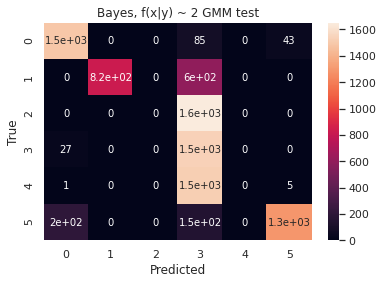

0

In [ ]:
plot_cm(cm,6,"Bayes, f(x|y) ~ 2 GMM test")

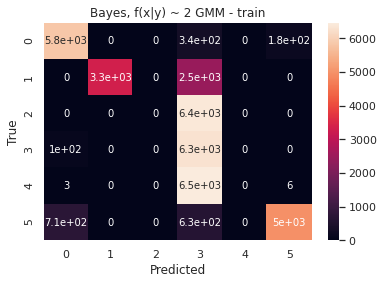

0.5417704744235357


In [ ]:
tmp_train = []
for i in range(len(k_folds)):
  if(i!=best_tup[3]):
    tmp_train.extend(k_folds[i])
tmp_train = key_feat_map(tmp_train)
out1 = tested_labs(tmp_train,best_tup[1],best_tup[2])

tr_cm = confusion_matrx(out1,6)
plot_cm(tr_cm,6,"Bayes, f(x|y) ~ 2 GMM - train")
print(accuracy(out1,6))

Experiments with Naive Bayes

In [ ]:
import pickle
with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/5Fold_3PCA.pickle","rb") as f:
  k_folds3 = pickle.load(f)

with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/testdict_3PCA.pickle","rb") as f:
  test_pca3 = pickle.load(f)


In [ ]:
#Naive bayes experiments
def MLE_uniGMM(data):
  num_comps = 2
  init_guess = generate_random_initguess(num_comps,1,0.1,20)
  print(init_guess)
  c,mu,sd = EM_GMMs(len(data),data,init_guess[0],init_guess[1],init_guess[2],50)
  #print(c)
  #print(mu)
  #print(sd)
  return [c,mu,sd]

def pdf_uniGMM(inpt,params):
  gmm_c,gmm_m,gmm_sd = params[0],params[1],params[2]
  val = 0
  for t in range(len(gmm_c)):
    val += gmm_c[t]*pdf_uniGauss(inpt,[gmm_m[t],gmm_sd[t]])
  return val

def MLE_uniGauss(data):
  #data has to be single feature ka array
  mu = np.sum(data)
  mu = mu/len(data)
  #print(mu)
  #print(data)
  #tmp = [(t - mu)**2 for t in data]
  tmp = 0
  for t in data:
    tmp += (t-mu)**2
  sd = (1/(len(data)))*(tmp)
  return [mu,math.sqrt(sd)]

def pdf_uniGauss(x,lst):
  mu = lst[0]
  sd = lst[1]
  if(sd==0):
    sd = 10**-4
  expt = (-0.5)*(x-mu)*(x-mu)*(1/sd)
  return (1/sd)*(0.5)*(1/(math.pi))*math.exp(expt)

def MLE_uniExp(data):
  #data has to be single feature ka array
  #would need to be modified to Laplacian agar neg features possible
  mu = 0
  lend = 0
  for t in data:
    if(t>=0):
      mu+=t
      lend+=1
  if(lend!=0):
    mu = mu/lend
  else:
    mu = 0
  return [mu]

def pdf_uniExp(x,mu1):
  if(x<0):
    return 0

  mu = mu1[0]
  if(mu<=0):
    return 0
 # print(mu)
  t = -x/mu
  if(t<-20):
    t = -10
  t = math.exp(t)
  t = t/mu
  if(math.isnan(t)):
    t=0
  return t

def MLE_uniUnf(data):
  #data has to be single feature ka array
  return [np.amax(data)-np.amin(data),np.amin(data),np.amax(data)]

def pdf_uniUnf(x,mu):
  a = mu[1]
  b = mu[2]
  if(x>a and x<b):
      return 1/mu[0]
  else:
    return 0

In [ ]:
#MLE for Naive Bayes || 

def MLE_predictLab_Naive(test,params_arr,fn_arr,priors):
  #all_vals = []
  max_val = (-1,0)
  #print(params_arr.keys())
  
  for key in params_arr.keys():
   #print(key)
    params = params_arr[key]
    val = 1
    
    for i in range(len(test)):
    #  print(test[i])
    #  print("asjkdniioeir")
    #  print(params[i])
    #  print("shefoiheior")
      pxi_y = fn_arr[i](test[i],params[i])
      val = val*pxi_y
    
    py = priors[int(key)] #equiprobable for now
    val = val*py

    if(max_val[0]==-1):
      max_val = (val,key)
    else:
      if(max_val[0]<val):
        max_val = (val,key)

  #print("boo") 
  return max_val[1] 

def MAP_expo_fXY_theta(lst):
  #[data,theta_prior_param]
  data = lst[0]
  #print(data)
  theta_prior_param = lst[1]
  n = 0
  val = 0
  for t in data:
    if(t>=0):
      val+=t
      n+=1
  #print(str(val)+" sdjidjioje")
  val = float(theta_prior_param[0]+val)
  return [n*(1/val)]

def MAP_gauss_fXY_theta_varfix(lst):
  #[data,theta_prior_params,var]
  data = lst[0]
  theta_prior_params = lst[1][0]
  var = lst[1][1]
  n = len(data)
  s = sum(data)
  sm2 = theta_prior_params[1]**2
  xv = (sm2*s + (var**2)*theta_prior_params[0])/(sm2*n+(var**2))
  return [xv,var]


def labels_mle_naive(test_dict1,params_arr,fn_arr,priors):
  dict_true_out = {}
  for k in test_dict1.keys():
    lst_feats = test_dict1[k]
    out_labels = []

    for feat in lst_feats:
      lbl = MLE_predictLab_Naive(feat,params_arr,fn_arr,priors)
      out_labels.append(lbl)

    dict_true_out[k] = out_labels
  
  return dict_true_out

def MLE_classify_Naive(train_dict,test_dict,MLE_arr,fn_arr,is_iid,priors,num_f,map_lst={}):
  
  #training
  params_arr = {}
  
  for key1 in train_dict.keys():
    lst_d = train_dict[key1]
    len_feat = len(lst_d[0])
    feat_params = []
    
    if(is_iid==1):
      for i in range(len_feat):
        xi = lst_d[:,i]
       # print(xi)
        fn = MLE_arr[i]
        if fn not in map_lst.keys(): 
          feat_params.append(fn(xi))
        else:
          
          feat_params.append(fn([xi,map_lst[fn]]))
      #print(feat_params)
    
    else:
      #build dict
      feat_params = [0 for t in range(len_feat)]
      #print(len_feat)
      MLE_dict = {}
      for i in range(len(MLE_arr)):
        key = MLE_arr[i]
        #print(key)
        if key in MLE_dict.keys():
          MLE_dict[key].append(i)
        else:
          MLE_dict[key] = [i]
      
      for fn in MLE_dict.keys():
        
        feats = MLE_dict[fn]
        #print(feats)
        data_all = list(lst_d[:,feats[0]])
        #print(feats)
        for j in range(1,len(feats)):
          #np.append(data_all,lst_d[:,feats[j]])
          data_all.extend(list(lst_d[:,feats[j]]))
        #print(data_all)
        if fn not in map_lst.keys(): 
          lst_params = fn(data_all)
        else:
          lst_params = fn([data_all,map_lst[fn]])
          #print(lst_params)
      #print(feat_params)
        for t in feats:
          feat_params[t] = lst_params
    
    params_arr[key1] = feat_params  

    #testing
  #print(params_arr)
  outp = labels_mle_naive(test_dict,params_arr,fn_arr,priors)
  return params_arr,accuracy(outp,num_f),confusion_matrx(outp,num_f)

In [ ]:
MLE_all = [MLE_uniGauss,MLE_uniExp,MLE_uniUnf,MLE_uniGMM, MAP_expo_fXY_theta, MAP_gauss_fXY_theta_varfix]
fn_all = [pdf_uniGauss,pdf_uniExp,pdf_uniUnf,pdf_uniGMM,pdf_uniExp, pdf_uniGauss]
#if tweaking functions maKE SURE YOU RECOMPILE THESE ARRAYS

In [ ]:
inx = [1,0,0,1,4]
MLE_arr = [MLE_all[i] for i in inx]
fn_arr = [fn_all[i] for i in inx]
f_dict = {MLE_all[4]:[5],MLE_all[5]:[[3,4],5]}

In [ ]:
from itertools import combinations_with_replacement, permutations

all_inx = []
cmb = combinations_with_replacement([0,1,2],3)

for t in list(cmb):
    print(t)
    pmt = permutations(t)
    #print(set(pmt))
    all_inx.extend(set(pmt))
    #break
#print(all_inx)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 1)
(0, 1, 2)
(0, 2, 2)
(1, 1, 1)
(1, 1, 2)
(1, 2, 2)
(2, 2, 2)


In [ ]:
def train_validation_spl(k_folds,i):
    #assert i<len(k_folds)
    temp_test = key_feat_map(k_folds[i])

    temp_train = []
    for j in range(len(k_folds)):
        if(j!=i):
          temp_train.extend(k_folds[j])
    
    tot_train = len(temp_train)
    temp_train = key_feat_map(temp_train)

    mle_p = np.ones(shape=6)
    for k in temp_train.keys():
        mle_p[int(k)] = len(temp_train[k])/tot_train
    return temp_test,temp_train,mle_p  

In [ ]:
#doing k-fold cv on this
best_acc = [-1]
all_acs = []
iid_v = 1

for inx in all_inx:
#f_dict = {MLE_all[4]:[5],MLE_all[5]:[[3,4],5]}
    #try:
     if(1==1): 
        MLE_arr = [MLE_all[i] for i in inx]
        fn_arr = [fn_all[i] for i in inx]
        f_dict = {MLE_all[4]:[5]}
        best_tup = [-1,list(),list(),0]
        num_comps = 2
        accs = np.zeros(len(k_folds3))
        best_testset = {}
        for i in range(len(k_folds3)):
          temp_test,temp_train,mle_p = train_validation_spl(k_folds3,i)

          params,acc,cf = MLE_classify_Naive(temp_train,temp_test,MLE_arr,fn_arr,iid_v,mle_p,6,f_dict)
          accs[i] = acc
          if(acc>best_tup[0]):
            best_tup = [acc,params,mle_p,i,cf]
            best_trset = temp_train

        test_acc = accuracy(labels_mle_naive(test_pca3,best_tup[1],fn_arr,best_tup[2]),6)
        if(test_acc>best_acc[0]):
            best_acc = [test_acc,inx]

        tr_out = labels_mle_naive(best_trset,best_tup[1],fn_arr,best_tup[2])
        train_acc = accuracy(tr_out,6)
        
        p,r,f,mf = precis_recall_f({},6,best_tup[4])
        result_row = [test_acc,train_acc,np.mean(accs),p,r,f,mf,best_tup[4],confusion_matrx(tr_out,6),inx]
        del(tr_out)
        #opt_params = best_tup[1]
        #traindict,valdict,mle_prior = train_validation_spl(k_folds3,best_tup[3])
        #num_pts = 150

        all_acs.append(result_row)
        
    # except:
    #     print("problem with " + str(inx))
    # #xax = np.linspace(0,1,num_pts,endpoint=False)
    #xtitle = "P(Y=0)"
    #plt_tstr_acc(test_acc,train_acc,mle_pt,xax,xtitle,"Naive Bayes, " +str(inx),"Downloads/NB_" + str(inx)+"_tstr_1.png")
    # return tpr,fpr,mle_pt,train_acc,test_acc,mle_accplt

In [ ]:
print(best_acc)

[0.9229921126282759, (2, 0, 0)]


In [ ]:
good_inx = []
for t in range(len(all_acs)):
  if(all_acs[t][0]>0.8):
    good_inx.append(t)
    #print(all_acs[t])

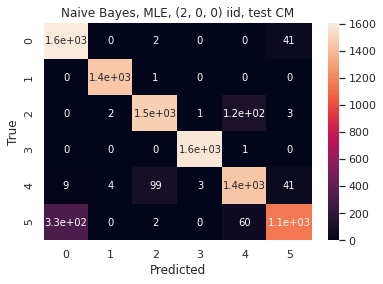

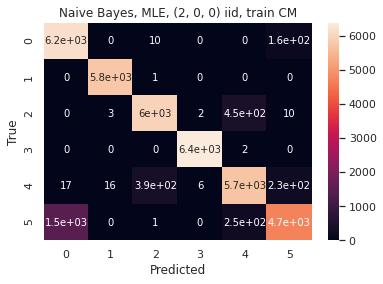

0.827  0.996  0.935  0.997  0.889  0.931
0.974  0.999  0.922  0.999  0.903  0.748
0.895  0.998  0.928  0.998  0.896  0.829


In [ ]:
for t in good_inx:
  val = all_acs[t]
  if(val[-1]==best_acc[1]):
    ts_vals = precis_recall_f({},6,val[-3])
    
    plot_cm(val[-3],6,"Naive Bayes, MLE, " + str(val[-1]) + " iid, test CM")
    plot_cm(val[-2],6,"Naive Bayes, MLE, " + str(val[-1]) + " iid, train CM")
    for i in range(0,3):
      t1 = list([round(k1,3) for k1 in ts_vals[i]])
      print(str(t1)[1:-1].replace(","," "))
  
  #print(val[-1])
  #print(str(val[-1])[1:-1].replace(", ",""))
  #print(str([round(k1,3) for k1 in val[:3]])[1:-1].replace(", "," "))
  #print(str([round(k1,3) for k1 in [val[6]]])[1:-1].replace(", "," "))

In [ ]:
all_acs1 = []
best_acc1 = [-1]
for t in good_inx:
    f_dict = {MLE_all[4]:[10],MLE_all[5]:[[2,10],5]}
    indx = list(all_inx[t])
    has_v = {}
    for indx_t in range(len(indx)):
        if(indx[indx_t]==0):
            indx[indx_t] = 5
            has_v[0] = indx_t
        if(indx[indx_t]==1):
            indx[indx_t] = 4
            has_v[1] = indx_t
    inx = indx     
    if(len(has_v.keys())>0): 
        MLE_arr = [MLE_all[i] for i in inx]
        fn_arr = [fn_all[i] for i in inx]
        #f_dict = {MLE_all[4]:[5]}
        best_tup = [-1,list(),list(),0]
        num_comps = 2
        accs = np.zeros(len(k_folds3))
        best_testset = {}
        for i in range(len(k_folds3)):
          temp_test,temp_train,mle_p = train_validation_spl(k_folds3,i)
  
          if 0 in has_v.keys():
              tr_dat = []
              for k in temp_train.keys():
                tr_dat.extend(temp_train[k])
              tr_dat = np.asarray(tr_dat)

              var = np.std(tr_dat[:,has_v[0]])
              f_dict[MLE_all[5]] = [[3,4],var]
          
          params,acc,cf = MLE_classify_Naive(temp_train,temp_test,MLE_arr,fn_arr,iid_v,mle_p,6,f_dict)
          accs[i] = acc
          if(acc>best_tup[0]):
            best_tup = [acc,params,mle_p,i,cf]
            best_testset = temp_train

        test_acc = accuracy(labels_mle_naive(test_pca3,best_tup[1],fn_arr,best_tup[2]),6)
        if(test_acc>best_acc1[0]):
            best_acc1 = [test_acc,inx]
        tr_out = labels_mle_naive(best_testset,best_tup[1],fn_arr,best_tup[2])
        train_acc = accuracy(tr_out,6)
        
        p,r,f,mf = precis_recall_f({},6,best_tup[4])
        result_row = [test_acc,train_acc,np.mean(accs),p,r,f,mf,best_tup[4],confusion_matrx(tr_out,6),inx]
        del(tr_out)
        #opt_params = best_tup[1]
        #traindict,valdict,mle_prior = train_validation_spl(k_folds3,best_tup[3])
        #num_pts = 150

        all_acs1.append(result_row)
        
    # except:
    #     print("problem with " + str(inx))
    # #xax = np.linspace(0,1,num_pts,endpoint=False)
    #xtitle = "P(Y=0)"
    #plt_tstr_acc(test_acc,train_acc,mle_pt,xax,xtitle,"Naive Bayes, " +str(inx),"Downloads/NB_" + str(inx)+"_tstr_1.png")
    # return tpr,fpr,mle_pt,train_acc,test_acc,mle_accplt

In [ ]:
for t in range(len(all_acs1)):
  val = all_acs1[t]
  if(val[-1]==best_acc1[1]):
    ts_vals = precis_recall_f({},6,val[-3])
    
    plot_cm(val[-3],6,"Naive Bayes, MAP, " + str(val[-1]) + " iid, test CM")
    plot_cm(val[-2],6,"Naive Bayes, MAP, " + str(val[-1]) + " iid, train CM")
    for i in range(0,3):
      t1 = list([round(k1,3) for k1 in ts_vals[i]])
      print(str(t1)[1:-1].replace(","," "))

  #print(str([round(k1,3) for k1 in val[:3]])[1:-1].replace(", "," "))
  #print(str([round(k1,3) for k1 in [val[6]]])[1:-1].replace(", "," "))

In [ ]:
# #doing k-fold cv on this
# best_tup = [-1,list(),list(),0]
# num_comps = 2
# for i in range(len(k_folds)):
#   temp_test = key_feat_map(k_folds[i])
  
#   temp_train = []
#   for j in range(len(k_folds)):
#     if(j!=i):
#       temp_train.extend(k_folds[j])
  
#   tot_train = len(temp_train)
  
#   temp_train = key_feat_map(temp_train)
  
#   mle_p = np.ones(shape=6)
#   for k in temp_train.keys():
#     mle_p[int(k)] = len(temp_train[k])/tot_train
  
#   params,acc = MLE_classify_Naive(temp_train,temp_test,MLE_arr,fn_arr,0,mle_p,6,f_dict)
#   if(acc>best_tup[0]):
#     best_tup = [acc,params,mle_p,i]
#   #break
# print(best_tup)

# #print(accuracy(dict_label_gauss(test_pca,best_tup[1],best_tup[2]),6))

Parzen window estimation

In [ ]:
import numpy as np
train_pca3 = k_folds3[0]
for i in range(1,5):
  train_pca3.extend(k_folds3[i])

train_pca3 = key_feat_map(train_pca3)

In [ ]:
#Parzen window est. 
from numba import jit,njit

def hypercube_fn(subs_vec,width=1):
  for t in subs_vec:
    if(np.abs(t)>(0.5*width)):
      return 0
  return 1
  
def gauss_kernel(subs_vec,width=1):
  d = len(subs_vec)
  expt = np.matmul(subs_vec[np.newaxis],np.transpose(subs_vec[np.newaxis]))
  
  return (width**d)*((math.pi)**(-0.5*d))*math.exp(expt*(-0.5/(width**2)))

@njit
def arr_label_est(inpt,train_pts,kernel_i,prior,width=1):
    #kerns = [gauss_kernel,hypercube_fn]
    #kernel = kerns[kernel_i]
     
    tmp_val = 0
    n = len(train_pts)
    d = len(train_pts[0])
    #print(n)
    #print(d)    
    for pt in range(len(train_pts)):
      in_vec = inpt - train_pts[pt]
      kern_v = 0
      if(kernel_i==0):
        d = len(in_vec)
        #expt = np.matmul(in_vec[np.newaxis],np.transpose(in_vec[np.newaxis]))
        #expt = sum([in_vec[t]**2 for t in range(len(in_vec))])
        expt = 0
        for t in range(len(in_vec)):
          expt += in_vec[t]**2
        kern_v = (width**d)*((math.pi)**(-0.5*d))*math.exp(expt*(-0.5/(width**2)))
      else:
        kern_v = 1
        for t in range(len(in_vec)):
          if(np.abs(in_vec[t])>(0.5*width)):
            kern_v = 0
      
      tmp_val += kern_v
    
    tmp_val = tmp_val/(n*(width**d))
    tmp_val = tmp_val*prior
    
    return tmp_val
    
def parzen_label_est(inpt,train_dict,kernel_i,prior,width=1):

  x=0
  px_y = (-1,0)
  
  for k in train_dict.keys():
    train_pts = train_dict[k]
    # tmp_val = 0
    # n = len(train_pts)
    # d = len(train_pts[0])
    # #print(n)
    # #print(d)    
    # for pt in train_pts:
    #   in_vec = inpt - pt
    #   tmp_val += kernel(in_vec,width)
    # tmp_val = tmp_val/(n*(width**d))
    # tmp_val = tmp_val*prior[int(k)]
    v_pri = prior[int(k)]
    tmp_val = arr_label_est(inpt,train_pts,kernel_i,v_pri,width)
    
    if(px_y[0]<tmp_val):
      px_y = (tmp_val,k)
  #print(px_y)
  return px_y[1]

def parzen_classify(train_dict,test_dict,kernel_i,prior,width,num_c):
  test_labs_dict = {}

  for k in test_dict.keys():
    datapts = test_dict[k]
    out_lab = []
    
    for t in datapts:
      out_lab.append(parzen_label_est(t,train_dict,kernel_i,prior,width))

    test_labs_dict[k] = out_lab
  
  return test_labs_dict,accuracy(test_labs_dict,num_c),confusion_matrx(test_labs_dict,num_c)

#https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#http://www.svcl.ucsd.edu/courses/ece271A/handouts/BayesIntro.pdf
#file:///D:/!Sem5/ML/assignments/409_2020_Assignment_1.pdf

In [ ]:
#doing k-fold cv on this
#inx = 0
#all_cm = []
all_b = []
#  best_tup = [-1,list(),list(),0]
  #num_comps = 2

temp_train = k_folds[0]
for i in range(1,len(k_folds)):
  temp_train.extend(k_folds[i])
tot_train = len(temp_train)
  
temp_train = key_feat_map(temp_train)
  
mle_p = np.ones(shape=6)
for k in temp_train.keys():
  mle_p[int(k)] = len(temp_train[k])/tot_train

for w in [1]:
  #w = (w/5)
  for kern in [0,1]:    
    out_d,acc,cm = parzen_classify(temp_train,test_pca,kern,mle_p,w,6)
    out_d,tr_acc,tr_cm = parzen_classify(temp_train,temp_train,kern,mle_p,w,6)
    all_b.append([kern,w,acc,tr_acc,mle_p,i,cm,tr_cm])
    
  #print(best_tup)
  #print(all_cm)
  #print(all_b)
  #with open("/content/drive/MyDrive/Assignment1_ELL409/Q3/Parzen" + str(inx) + "_5Fold_5PCA.pickle","wb") as f:
  #  pickle.dump([all_cm,all_b],f)
  #inx+=1
  #print(accuracy(dict_label_gauss(test_pca,best_tup[1],best_tup[2]),6))

In [ ]:
for t in all_b:
  print(round(t[2],3))
  print(round(t[3],3))
  p1 = precis_recall_f({},6,t[6])
  print(round(p1[-1],3))
  print(str([round(k1,3) for k1 in p1[0]])[1:-1].replace(","," "))
  print(str([round(k1,3) for k1 in p1[1]])[1:-1].replace(","," "))
  print(str([round(k1,3) for k1 in p1[2]])[1:-1].replace(","," "))
  # p1 = precis_recall_f({},6,t[7])
  # print(round(p1[-1],3))
  # print(str([round(k1,3) for k1 in p1[0]])[1:-1].replace(","," "))
  # print(str([round(k1,3) for k1 in p1[1]])[1:-1].replace(","," "))
  # print(str([round(k1,3) for k1 in p1[2]])[1:-1].replace(","," "))

In [ ]:
for v in all_b:
  plot_cm(v[6],6,"parzen, test CM " + str(v[0]))
  plot_cm(v[7],6,"parzen, train CM " + str(v[0]))
  

In [ ]:
# lst = [[0.8357142857142857, 0.8205128205128205, 1.0, 0.9014084507042254, 0.8624999999999999, 0.8682716568544995, (0, 0, 1)],
# [0.8285714285714286, 0.8205128205128205, 1.0, 0.9014084507042254, 0.8571428571428571, 0.8624894869638351, (0, 0, 2)],
# [0.8285714285714286, 0.9230769230769231, 0.9024390243902439, 0.9126413155190134, 0.8642857142857144, 0.8147603027754415, (0, 1, 1)],
# [0.8285714285714286, 0.875, 0.925, 0.8993055555555557, 0.85, 0.7683978132884777, (1, 0, 1)],
# [0.8142857142857143, 0.8780487804878049, 0.8974358974358975, 0.8876364917224375, 0.8535714285714285, 0.7989907485281749, (0, 1, 2)],
# [0.8357142857142857, 0.8780487804878049, 0.9487179487179487, 0.9120164327285175, 0.8553571428571428, 0.7586206896551724, (2, 0, 1)],
# [0.8214285714285714, 0.8461538461538461, 0.9512195121951219, 0.8956158663883089, 0.8607142857142858, 0.7894238856181665, (0, 2, 1)],
# [0.8285714285714286, 0.875, 0.925, 0.8993055555555557, 0.8517857142857143, 0.7642977291841883, (1, 0, 2)],
# [0.8357142857142857, 0.875, 0.925, 0.8993055555555557, 0.7964285714285714, 0.811816652649285, (3, 0, 1)],
# [0.8428571428571429, 0.875, 0.925, 0.8993055555555557, 0.8553571428571428, 0.7748107653490328, (2, 0, 2)],
# [0.8071428571428572, 0.9230769230769231, 0.9024390243902439, 0.9126413155190134, 0.8625, 0.7720773759461731, (0, 2, 2)],
# [0.8357142857142857, 0.875, 0.925, 0.8993055555555557, 0.8303571428571429, 0.7641925988225399, (3, 0, 2)],
# [0.8142857142857143, 0.918918918918919, 0.8604651162790697, 0.8887318968562347, 0.8017857142857142, 0.9257779646761986, (3, 1, 1)],
# [0.8214285714285714, 0.8947368421052632, 0.9047619047619048, 0.8997214484679666, 0.8624999999999999, 0.9131623212783851, (3, 1, 2)],
# [0.8142857142857143, 0.868421052631579, 0.9523809523809523, 0.9084652443220921, 0.8571428571428571, 0.8988645920941968, (3, 2, 1)]]

# for t in range(len(lst)):
#   t1 = []
#   t1.append(str(lst[t][-1]).replace(",","-"))
#   t1.extend([round(k,3) for k in lst[t][:-1]])
#   print(str(t1)[1:-1].replace(","," "))
#   #break